In [1]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install networkx
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import torch_geometric.loader
# from torch.utils.data import DataLoader
from torch_geometric.datasets import UPFD
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear
from sklearn.metrics import accuracy_score, f1_score

In [3]:
import matplotlib.pyplot as plt

In [4]:
from torch_geometric.loader import DataLoader

GOSSIPCOP

In [40]:
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))
# why is the training set smaller hello

Train Samples:  1092
Test Samples:  3826


In [41]:
sample_id=1
train_data[sample_id].edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

In [42]:
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

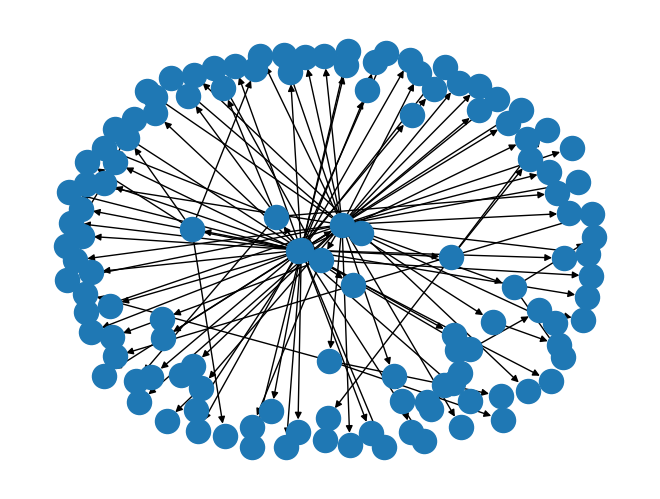

In [43]:
nx.draw(to_networkx(train_data[sample_id]))

In [44]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([125, 310])


tensor([[0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529],
        [0.4610, 0.4544, 0.6279,  ..., 0.2055, 0.1667, 0.2500],
        [0.4461, 0.4728, 0.4978,  ..., 0.8356, 0.0556, 0.0000],
        ...,
        [0.5574, 0.4934, 0.5588,  ..., 0.3562, 0.0556, 0.2647],
        [0.5274, 0.5889, 0.4425,  ..., 0.9589, 0.1111, 0.1176],
        [0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529]])

Text(0.5, 0, 'Class')

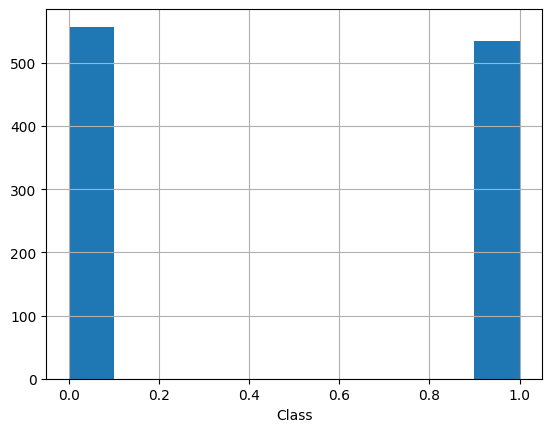

In [45]:
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()
plt.xlabel('Class')

In [46]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [47]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs

    accuracy = correct / total_samples
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss, accuracy

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs
        all_preds.append(preds)
        all_labels.append(data.y)

    accuracy = correct / total_samples
    avg_loss = total_loss / len(test_loader.dataset)

    # Calculate Metrics
    f1 = f1_score(torch.cat(all_preds), torch.cat(all_labels))

    return avg_loss, accuracy, f1


In [50]:
for epoch in range(40):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.4f} | '
          f'TestLoss: {test_loss:.4f} | TrainAcc: {train_acc:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')

Epoch: 00 |  TrainLoss: 0.3177 | TestLoss: 0.2859 | TrainAcc: 0.8956 | TestAcc: 0.9336 | TestF1: 0.9331
Epoch: 01 |  TrainLoss: 0.2912 | TestLoss: 0.2848 | TrainAcc: 0.9130 | TestAcc: 0.9334 | TestF1: 0.9352
Epoch: 02 |  TrainLoss: 0.3055 | TestLoss: 0.3069 | TrainAcc: 0.9048 | TestAcc: 0.8910 | TestF1: 0.8812
Epoch: 03 |  TrainLoss: 0.3007 | TestLoss: 0.2820 | TrainAcc: 0.9038 | TestAcc: 0.9266 | TestF1: 0.9245
Epoch: 04 |  TrainLoss: 0.2934 | TestLoss: 0.3481 | TrainAcc: 0.9075 | TestAcc: 0.8280 | TestF1: 0.7958
Epoch: 05 |  TrainLoss: 0.3036 | TestLoss: 0.2690 | TrainAcc: 0.8929 | TestAcc: 0.9375 | TestF1: 0.9377
Epoch: 06 |  TrainLoss: 0.2944 | TestLoss: 0.2980 | TrainAcc: 0.8993 | TestAcc: 0.8934 | TestF1: 0.8840
Epoch: 07 |  TrainLoss: 0.3081 | TestLoss: 0.2643 | TrainAcc: 0.8874 | TestAcc: 0.9383 | TestF1: 0.9383
Epoch: 08 |  TrainLoss: 0.3020 | TestLoss: 0.2678 | TrainAcc: 0.8938 | TestAcc: 0.9370 | TestF1: 0.9391
Epoch: 09 |  TrainLoss: 0.2683 | TestLoss: 0.3013 | TrainAcc: 0.

In [51]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.829138   1.0     1
1    0.723127   1.0     1
2    0.238053   0.0     0
3    0.682170   1.0     1
4    0.038770   0.0     0
5    0.180997   0.0     0
6    0.104137   0.0     0
7    0.916189   1.0     1
8    0.044738   0.0     0
9    0.102911   0.0     0


POLITIFACT

In [52]:
train_data = UPFD(root=".", name="politifact", feature="content", split="train")
test_data = UPFD(root=".", name="politifact", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Train Samples:  62
Test Samples:  221


In [53]:
sample_id=1
train_data[sample_id].edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  5,  5,  7,  7,  7,  7,
          7,  7,  7,  9, 10, 12, 14, 21, 21, 21, 28, 29, 30],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 28, 13, 14, 15, 25, 26, 27, 29, 30, 31]])

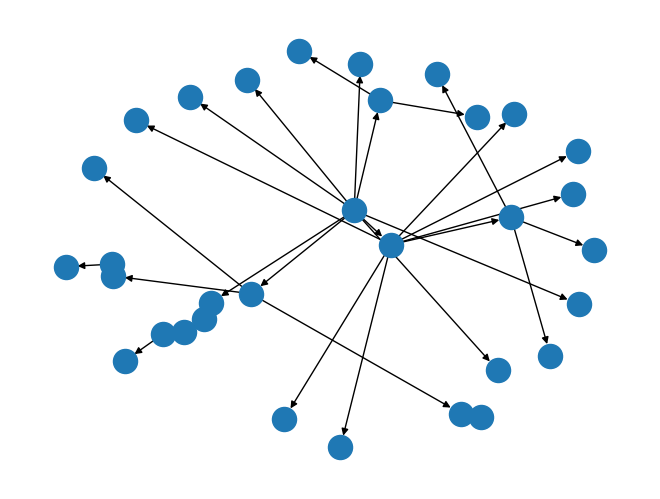

In [54]:
nx.draw(to_networkx(train_data[sample_id]))

In [55]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([32, 310])


tensor([[0.5925, 0.5378, 0.4042,  ..., 0.5653, 0.1481, 0.4124],
        [0.5514, 0.4770, 0.3302,  ..., 0.9189, 0.2308, 0.1081],
        [0.5925, 0.5378, 0.4042,  ..., 0.5653, 0.1481, 0.4124],
        ...,
        [0.6579, 0.5423, 0.4706,  ..., 0.7230, 0.1538, 0.3243],
        [0.6579, 0.5423, 0.4706,  ..., 0.7230, 0.1538, 0.3243],
        [0.6579, 0.5423, 0.4706,  ..., 0.7230, 0.1538, 0.3243]])

Text(0.5, 0, 'Class')

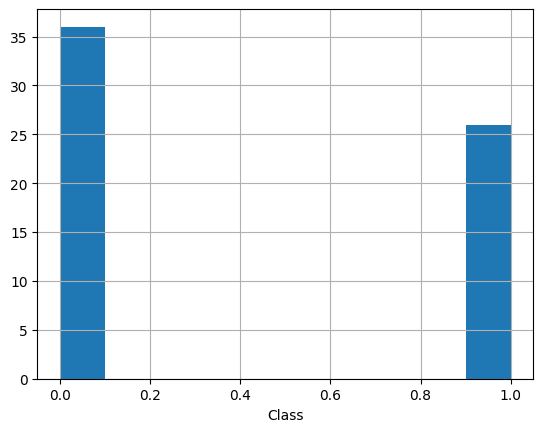

In [56]:
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()
plt.xlabel('Class')

In [57]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [58]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs

    accuracy = correct / total_samples
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss, accuracy

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs
        all_preds.append(preds)
        all_labels.append(data.y)

    accuracy = correct / total_samples
    avg_loss = total_loss / len(test_loader.dataset)

    # Calculate Metrics
    f1 = f1_score(torch.cat(all_preds), torch.cat(all_labels))

    return avg_loss, accuracy, f1

In [62]:
for epoch in range(40):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.4f} | '
          f'TestLoss: {test_loss:.4f} | TrainAcc: {train_acc:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')

Epoch: 00 |  TrainLoss: 0.5167 | TestLoss: 0.5328 | TrainAcc: 0.5968 | TestAcc: 0.7330 | TestF1: 0.7900
Epoch: 01 |  TrainLoss: 0.5261 | TestLoss: 0.6329 | TrainAcc: 0.7258 | TestAcc: 0.4977 | TestF1: 0.0348
Epoch: 02 |  TrainLoss: 0.5240 | TestLoss: 0.5085 | TrainAcc: 0.5968 | TestAcc: 0.8100 | TestF1: 0.8359
Epoch: 03 |  TrainLoss: 0.4833 | TestLoss: 0.5240 | TrainAcc: 0.8548 | TestAcc: 0.7783 | TestF1: 0.7351
Epoch: 04 |  TrainLoss: 0.4578 | TestLoss: 0.5221 | TrainAcc: 0.8871 | TestAcc: 0.7783 | TestF1: 0.7351
Epoch: 05 |  TrainLoss: 0.4547 | TestLoss: 0.5003 | TrainAcc: 0.8871 | TestAcc: 0.8100 | TestF1: 0.8359
Epoch: 06 |  TrainLoss: 0.4733 | TestLoss: 0.6416 | TrainAcc: 0.8548 | TestAcc: 0.5023 | TestF1: 0.0517
Epoch: 07 |  TrainLoss: 0.5237 | TestLoss: 0.5517 | TrainAcc: 0.5968 | TestAcc: 0.6697 | TestF1: 0.7542
Epoch: 08 |  TrainLoss: 0.5568 | TestLoss: 0.6710 | TrainAcc: 0.6290 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 09 |  TrainLoss: 0.5425 | TestLoss: 0.4864 | TrainAcc: 0.

In [29]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.464092   0.0     1
1    0.336350   0.0     1
2    0.640570   1.0     1
3    0.615638   1.0     1
4    0.100623   0.0     0
5    0.314329   0.0     0
6    0.662283   1.0     1
7    0.060959   0.0     0
8    0.748997   1.0     1
9    0.246669   0.0     0
